In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertConfig
import torch.optim as optim
from torch.nn import MSELoss, TransformerEncoder, TransformerEncoderLayer
import pandas as pd
import numpy as np
import os
import time
import librosa
import matplotlib.pyplot as plt

In [3]:
#lstm - TS
class MusicGenerationModel(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_dim=512, lstm_hidden_dim=256, output_dim=256, n_lstm_layers=2, dropout=0.1):
        super(MusicGenerationModel, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        self.text_encoder = BertModel.from_pretrained(bert_model_name)
        
        self.fc_text_to_lstm = nn.Linear(self.text_encoder.config.hidden_size, lstm_hidden_dim)
        self.lstm = nn.LSTM(lstm_hidden_dim, lstm_hidden_dim, n_lstm_layers, batch_first=True, dropout=dropout)
        self.fc_lstm_to_output = nn.Linear(lstm_hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, text_description, seq_length=420):
        # Tokenize and encode the input text description
        encoded_input = self.tokenizer(text_description, return_tensors='pt', padding=True, truncation=True).to(next(self.parameters()).device)
        with torch.no_grad():
            text_embeddings = self.text_encoder(**encoded_input).last_hidden_state

        # Use the [CLS] token's embedding as the representation of the entire sequence
        cls_embedding = text_embeddings[:, 0, :]  # Extract the [CLS] token embedding
        
        # Map the text embedding to the LSTM hidden dimension size
        lstm_input = self.fc_text_to_lstm(cls_embedding).unsqueeze(1)  # Shape: (batch_size, 1, lstm_hidden_dim)
        
        # Initialize hidden and cell states for the LSTM
        h_0 = torch.zeros(self.lstm.num_layers, lstm_input.size(0), self.lstm.hidden_size).to(next(self.parameters()).device)
        c_0 = torch.zeros(self.lstm.num_layers, lstm_input.size(0), self.lstm.hidden_size).to(next(self.parameters()).device)
        
        # Sequentially generate each value in the spectrogram
        outputs = []
        lstm_output, (h_t, c_t) = self.lstm(lstm_input, (h_0, c_0))
        for _ in range(seq_length):
            lstm_output, (h_t, c_t) = self.lstm(lstm_output, (h_t, c_t))
            output = self.fc_lstm_to_output(lstm_output)
            outputs.append(output)
            lstm_output = output  # Feed the current output as the next input
        
        audio_output = torch.cat(outputs, dim=1).squeeze(2)  # Concatenate all outputs along the sequence length dimension
        audio_output = audio_output.squeeze(0)  # Remove the first dimension of size 1, resulting in shape [431, 256]
        audio_output = audio_output.transpose(0, 1)
        
        return audio_output

In [4]:
# model_state_dict = torch.load('/kaggle/input/musicgenerator/pytorch/1out_395mse/1/best_model.pth',map_location=torch.device('cpu'))
# model_state_dict = torch.load('/kaggle/input/musicgenerator/pytorch/trans_179mse/1/best_model.pth',map_location=torch.device('cpu'))
model_state_dict = torch.load('/kaggle/input/musicgenerator/pytorch/lstm_ts_198mse/1/best_model.pth',map_location=torch.device('cpu'))
# model_state_dict

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MusicGenerationModel()
model.load_state_dict(model_state_dict['model_state_dict'])
model.eval()  # Set the model to evaluation mode
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

MusicGenerationModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [6]:
# text_descriptions = ['piano', 'drums']
text_descriptions = 'The low quality recording features a ballad song that contains sustained strings, mellow piano melody and soft female vocal singing over it. It sounds sad and soulful, like something you would hear at Sunday services.'
# text_descriptions = 'silence'

# Generate music spectrogram
with torch.no_grad():
    audio_output = model(text_descriptions)

In [ ]:
# audio_output = audio_output.mean(dim=0)
# audio_output = audio_output.permute(1, 0)
audio_output.shape

In [7]:
def plot_mel_spectrogram(mel_spectrogram, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.show()

In [8]:
audio_output.cpu().detach().numpy().max()

-30.00992

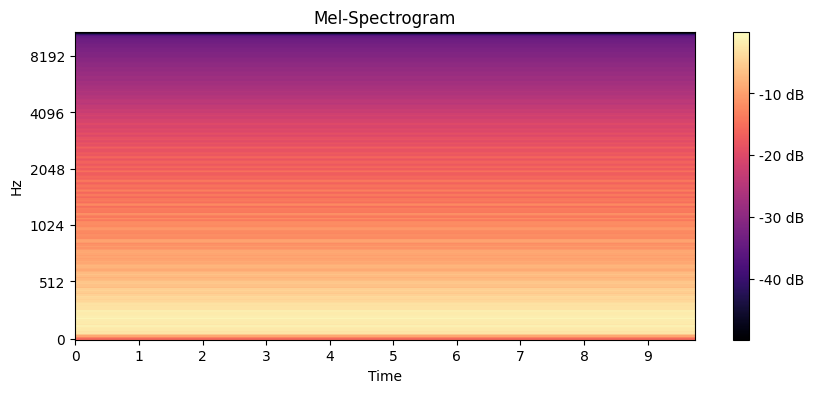

In [9]:
plot_mel_spectrogram(audio_output.cpu().detach().numpy()+30, 22050)

In [49]:
import soundfile as sf

def mel_spectrogram_to_audio(mel_spectrogram, sr, n_iter=128, n_fft=2048, hop_length=512, win_length=None):
    """
    Convert a Mel-spectrogram back to an audio signal.
    """
    if win_length is None:
        win_length = n_fft
    
    # Convert back to linear scale from dB
    mel_spectrogram = librosa.db_to_power(mel_spectrogram)
    
    # Create a Mel filter bank
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=mel_spectrogram.shape[0])
    
    # Invert the Mel filter bank
    inv_mel_basis = np.linalg.pinv(mel_basis)
    
    # Reconstruct the spectrogram
    S = np.dot(inv_mel_basis, mel_spectrogram)
    
    # Apply Griffin-Lim algorithm to recover the phase
    audio = librosa.griffinlim(S, n_iter=n_iter, hop_length=hop_length, win_length=win_length)
    
    return audio

In [86]:
audio = mel_spectrogram_to_audio(audio_output.cpu().detach().numpy()+30, 22050)

In [87]:
sf.write("aduio_model_179.wav", audio, 22050)

print(f"Reconstructed audio saved")

Reconstructed audio saved
